# Supervised Learning (Classification)

In supervised learning, the task is to infer hidden structure from
labeled data, comprised of training examples $\{(x_n, y_n)\}$.
Classification means the output $y$ takes discrete values.

We demonstrate with an example in Edward. A webpage version is available at
http://edwardlib.org/tutorials/supervised-classification.

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf

from edward.models import Bernoulli, MultivariateNormalTriL, Normal
from edward.util import rbf
from observations import crabs

In [3]:
ed.set_seed(42)

## Data

Use the
[crabs data set](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/crabs.html),
which consists of morphological measurements on a crab species. We
are interested in predicting whether a given crab has the color form
blue (encoded as 0) or orange (encoded as 1). We use all the numeric features
in the dataset.

In [4]:

data, metadata = crabs("~/data")
X_train = data[:200, 3:]
y_train = data[:200, 1]

N = X_train.shape[0]  # number of data points
D = X_train.shape[1]  # number of features

print("Number of data points: {}".format(N))
print("Number of features: {}".format(D))

Number of data points: 200
Number of features: 5


In [5]:
y_train

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

## Model

A Gaussian process is a powerful object for modeling nonlinear
relationships between pairs of random variables. It defines a distribution over
(possibly nonlinear) functions, which can be applied for representing
our uncertainty around the true functional relationship.
Here we define a Gaussian process model for classification
(Rasumussen & Williams, 2006).

Formally, a distribution over functions $f:\mathbb{R}^D\to\mathbb{R}$ can be specified
by a Gaussian process
$$
\begin{align*}
  p(f)
  &=
  \mathcal{GP}(f\mid \mathbf{0}, k(\mathbf{x}, \mathbf{x}^\prime)),
\end{align*}
$$
whose mean function is the zero function, and whose covariance
function is some kernel which describes dependence between
any set of inputs to the function.

Given a set of input-output pairs
$\{\mathbf{x}_n\in\mathbb{R}^D,y_n\in\mathbb{R}\}$,
the likelihood can be written as a multivariate normal

\begin{align*}
  p(\mathbf{y})
  &=
  \text{Normal}(\mathbf{y} \mid \mathbf{0}, \mathbf{K})
\end{align*}

where $\mathbf{K}$ is a covariance matrix given by evaluating
$k(\mathbf{x}_n, \mathbf{x}_m)$ for each pair of inputs in the data
set.

The above applies directly for regression where $\mathbb{y}$ is a
real-valued response, but not for (binary) classification, where $\mathbb{y}$
is a label in $\{0,1\}$. To deal with classification, we interpret the
response as latent variables which is squashed into $[0,1]$. We then
draw from a Bernoulli to determine the label, with probability given
by the squashed value.

Define the likelihood of an observation $(\mathbf{x}_n, y_n)$ as

\begin{align*}
  p(y_n \mid \mathbf{z}, x_n)
  &=
  \text{Bernoulli}(y_n \mid \text{logit}^{-1}(\mathbf{x}_n^\top \mathbf{z})).
\end{align*}

Define the prior to be a multivariate normal

\begin{align*}
  p(\mathbf{z})
  &=
  \text{Normal}(\mathbf{z} \mid \mathbf{0}, \mathbf{K}),
\end{align*}

with covariance matrix given as previously stated.

Let's build the model in Edward. We use a radial basis function (RBF)
kernel, also known as the squared exponential or exponentiated
quadratic. It returns the kernel matrix evaluated over all pairs of
data points; we then Cholesky decompose the matrix to parameterize the
multivariate normal distribution.

In [6]:
K = 2    # number of classes.


In [7]:
from edward.models import Categorical, Normal


In [8]:
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
b = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y = Categorical(tf.matmul(x,w)+b)

In [9]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw = Normal(loc=tf.Variable(tf.random_normal([D, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K])))) 
qb = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

In [23]:
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.BB_alpha({w: qw, b: qb}, data={x: X_train,y: y_train})
alpha = 0.001

Here, we define a placeholder `X`. During inference, we pass in
the value for this placeholder according to data.

## Inference

Perform variational inference.
Define the variational model to be a fully factorized normal.

Run variational inference for `30000` iterations.

In [24]:
#inference = ed.BB_alpha({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_iter=30000,alpha=alpha)

30000/30000 [100%] ██████████████████████████████ Elapsed: 54s | Loss: 71.528


In [1]:
ed.evaluate('categorical_accuracy', data={x: X_train,y: y_train})


NameError: name 'ed' is not defined

In this case
`KLqp` defaults to minimizing the
$\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient.
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](/tutorials/klqp).
(This example happens to be slow because evaluating and inverting full
covariances in Gaussian processes happens to be slow.)

In [21]:
X_train.dtype

dtype('float64')

In [21]:

# Generate samples the posterior and store them.
n_samples = 100
prob_lst = []
samples = []
w_samples = []
b_samples = []
for _ in range(n_samples):
    w_samp = qw.sample()
    b_samp = qb.sample()
    w_samples.append(w_samp)
    b_samples.append(b_samp)
    # Also compue the probabiliy of each class for each (w,b) sample.
    prob = tf.nn.softmax(tf.matmul( X_train.astype('float32'),w_samp ) + b_samp)
    prob_lst.append(prob.eval())
    sample = tf.concat([tf.reshape(w_samp,[-1]),b_samp],0)
    samples.append(sample.eval())

In [13]:
import matplotlib.pyplot as plt

## KLqp

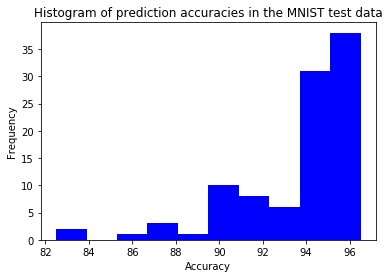

In [14]:
# Compute the accuracy of the model. 
# For each sample we compute the predicted class and compare with the test labels.
# Predicted class is defined as the one which as maximum proability.
# We perform this test for each (w,b) in the posterior giving us a set of accuracies
# Finally we make a histogram of accuracies for the test data.
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == y_train).mean()*100
    accy_test.append(acc)

plt.hist(accy_test,color='b')
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")

klqp = accy_test

## BB-$\alpha$ ; $\alpha = 1.0$

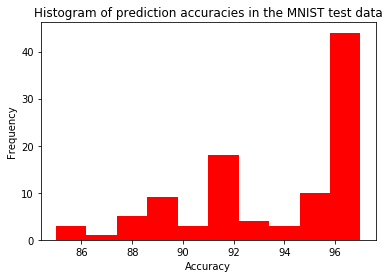

In [18]:
# Compute the accuracy of the model. 
# For each sample we compute the predicted class and compare with the test labels.
# Predicted class is defined as the one which as maximum proability.
# We perform this test for each (w,b) in the posterior giving us a set of accuracies
# Finally we make a histogram of accuracies for the test data.
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == y_train).mean()*100
    accy_test.append(acc)

plt.hist(accy_test,color='r')
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")

alpha_10 = accy_test

## BB-$\alpha$ ; $\alpha = 0.5$

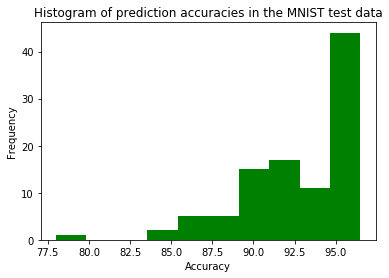

In [22]:
# Compute the accuracy of the model. 
# For each sample we compute the predicted class and compare with the test labels.
# Predicted class is defined as the one which as maximum proability.
# We perform this test for each (w,b) in the posterior giving us a set of accuracies
# Finally we make a histogram of accuracies for the test data.
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == y_train).mean()*100
    accy_test.append(acc)

plt.hist(accy_test,color='g')
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")

alpha_05 = accy_test

## BB-$\alpha$ ; $\alpha = 0.001$

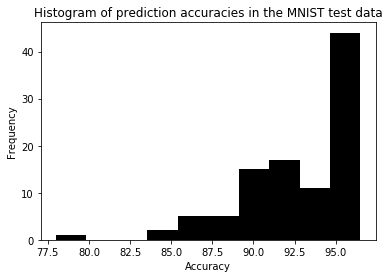

In [25]:
# Compute the accuracy of the model. 
# For each sample we compute the predicted class and compare with the test labels.
# Predicted class is defined as the one which as maximum proability.
# We perform this test for each (w,b) in the posterior giving us a set of accuracies
# Finally we make a histogram of accuracies for the test data.
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == y_train).mean()*100
    accy_test.append(acc)

plt.hist(accy_test,color='k')
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")

alpha_001 = accy_test

## Plotting error bars

In [26]:
c = np.stack((alpha_001,alpha_05,alpha_10,klqp))
n = len(c)

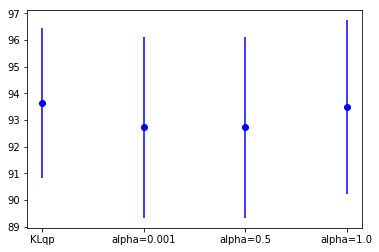

[ 89.5  96.   89.5  87.   87.   96.   95.5  84.   95.   96.   92.5  87.
  91.5  87.   95.   88.5  78.   90.5  91.5  88.   92.   95.5  89.5  89.
  95.5  96.   90.   89.5  94.5  96.   96.   96.   95.5  96.   95.   95.5
  94.   95.   95.   91.5  94.5  90.5  95.   92.   96.   96.   89.5  89.5
  94.   87.   95.   84.   94.   90.   95.5  95.5  95.   96.5  96.   96.
  91.   92.   93.5  95.5  95.5  90.   94.   96.   92.5  96.   95.5  89.5
  95.5  90.   93.   96.   94.   95.5  95.5  93.   95.   91.5  91.5  92.
  89.   90.5  91.   94.5  96.   92.5  92.5  89.   95.   96.   89.5  91.5
  91.5  96.   95.5  95. ]
[ 89.5  96.   89.5  87.   87.   96.   95.5  84.   95.   96.   92.5  87.
  91.5  87.   95.   88.5  78.   90.5  91.5  88.   92.   95.5  89.5  89.
  95.5  96.   90.   89.5  94.5  96.   96.   96.   95.5  96.   95.   95.5
  94.   95.   95.   91.5  94.5  90.5  95.   92.   96.   96.   89.5  89.5
  94.   87.   95.   84.   94.   90.   95.5  95.5  95.   96.5  96.   96.
  91.   92.   93.5  95.5  95.5  

[None, None, None, None]

In [28]:
x=['alpha=0.001','alpha=0.5','alpha=1.0','KLqp']
y =[np.mean(c[i]) for i in range(0,n)]
e =[np.sqrt(np.var((c[i]))) for i in range(0,n)]
plt.errorbar(x, y, yerr=e, fmt='o',color='b')
plt.show()

[print(c[i]) for i in range(0,n)]

In [34]:
d = 100.0 - c

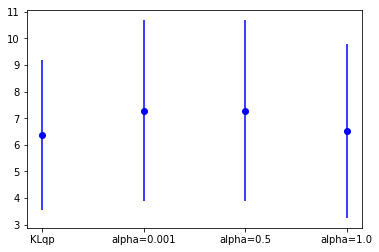

[ 10.5   4.   10.5  13.   13.    4.    4.5  16.    5.    4.    7.5  13.
   8.5  13.    5.   11.5  22.    9.5   8.5  12.    8.    4.5  10.5  11.
   4.5   4.   10.   10.5   5.5   4.    4.    4.    4.5   4.    5.    4.5
   6.    5.    5.    8.5   5.5   9.5   5.    8.    4.    4.   10.5  10.5
   6.   13.    5.   16.    6.   10.    4.5   4.5   5.    3.5   4.    4.
   9.    8.    6.5   4.5   4.5  10.    6.    4.    7.5   4.    4.5  10.5
   4.5  10.    7.    4.    6.    4.5   4.5   7.    5.    8.5   8.5   8.
  11.    9.5   9.    5.5   4.    7.5   7.5  11.    5.    4.   10.5   8.5
   8.5   4.    4.5   5. ]
[ 10.5   4.   10.5  13.   13.    4.    4.5  16.    5.    4.    7.5  13.
   8.5  13.    5.   11.5  22.    9.5   8.5  12.    8.    4.5  10.5  11.
   4.5   4.   10.   10.5   5.5   4.    4.    4.    4.5   4.    5.    4.5
   6.    5.    5.    8.5   5.5   9.5   5.    8.    4.    4.   10.5  10.5
   6.   13.    5.   16.    6.   10.    4.5   4.5   5.    3.5   4.    4.
   9.    8.    6.5   4.5   4.5  

[None, None, None, None]

In [35]:
x=['alpha=0.001','alpha=0.5','alpha=1.0','KLqp']
y2 =[np.mean(d[i]) for i in range(0,n)]
e2 =[np.sqrt(np.var((d[i]))) for i in range(0,n)]
plt.errorbar(x, y2, yerr=e2, fmt='o',color='b')
plt.show()

[print(d[i]) for i in range(0,n)]